In [1]:
#Lets have matplotlib "inline"
%matplotlib notebook

#Import packages we need
import numpy as np
import os
import subprocess
from matplotlib import animation, rc
from matplotlib import pyplot as plt

In [2]:
#Misc plotting setup
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#Set large figure sizes
#plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'
#plt.rcParams['legend.markerscale'] = 1.0
#plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.markeredgewidth'] = 1.5
#plt.rcParams['savefig.dpi'] = 400

In [3]:
def gen_reference(nx):
    csv_filename = 'shock1d_ref_nx=' + str(nx) + '.csv'

    #If we do not have the data, generate it    
    if (not os.path.isfile(csv_filename)):
        print("Generating new reference!")
        swashes_path = r'C:\Users\anbro\Documents\programs\SWASHES-1.03.00_win\bin\swashes_win.exe'

        swashes_args = [\
                        '1', # 1D problems \
                        '3', # Dam breaks \
                        '1', # Domain 1 \
                        '1', # Wet domain no friction
                        str(nx) #Number of cells X
                       ]

        with open(csv_filename, 'w') as csv_file:
            p = subprocess.check_call([swashes_path] + swashes_args, stdout=csv_file)

    reference = np.genfromtxt(csv_filename, comments='#', delimiter='\t', skip_header=0, usecols=(0, 1, 2))
    x, h, u = reference[:, 0], reference[:, 1], reference[:, 2]
    return x, h, h*u

"""
ref_x, ref_h, _ = gen_reference(512)
plt.plot(ref_x, ref_h, '-', label='Reference')
plt.title("Reference data")
plt.legend()
plt.show()
"""

'\nref_x, ref_h, _ = gen_reference(512)\nplt.plot(ref_x, ref_h, \'-\', label=\'Reference\')\nplt.title("Reference data")\nplt.legend()\nplt.show()\n'

In [4]:
def WAF_minmod(r_, c_):
    return 1.0 - (1.0 - abs(c_)) * max(0.0, min(1.0, r_));

"""
r = np.linspace(-1.0, 2.0, 10)
c = -15*np.ones_like(r)

x = r
y = list(map(WAF_minmod, r, c))

plt.figure()
plt.plot(x, y)
plt.title("WAF minmod limiter")
plt.show()
"""

'\nr = np.linspace(-1.0, 2.0, 10)\nc = -15*np.ones_like(r)\n\nx = r\ny = list(map(WAF_minmod, r, c))\n\nplt.figure()\nplt.plot(x, y)\nplt.title("WAF minmod limiter")\nplt.show()\n'

In [5]:
def F_func(Q, g):
    F = np.zeros(3)

    F[0] = Q[1];                                 #hu
    F[1] = Q[1]*Q[1] / Q[0] + 0.5*g*Q[0]*Q[0];   #hu*hu/h + 0.5f*g*h*h;
    F[2] = Q[1]*Q[2] / Q[0];                     #hu*hv/h;

    return F;

def F_func_helper(h, hu):
    return F_func(np.array([h, hu, 0.0]), 9.81)

"""
ref_x, ref_h, ref_hu = gen_reference(512)
F = np.array(list(map(F_func_helper, ref_h, ref_hu)))

fig, ax1 = plt.subplots()
plt.ylim([0, 0.01])
ax2 = ax1.twinx()

ax1.plot(ref_x, ref_h, '-', label='Reference')

ax2.plot(ref_x, F[:,0], ':', label='F_0')
ax2.plot(ref_x, F[:,1], '.-', label='F_1')
ax2.plot(ref_x, F[:,2], '--', label='F_2')

plt.title("Flux function for shallow water")
plt.legend()
"""

'\nref_x, ref_h, ref_hu = gen_reference(512)\nF = np.array(list(map(F_func_helper, ref_h, ref_hu)))\n\nfig, ax1 = plt.subplots()\nplt.ylim([0, 0.01])\nax2 = ax1.twinx()\n\nax1.plot(ref_x, ref_h, \'-\', label=\'Reference\')\n\nax2.plot(ref_x, F[:,0], \':\', label=\'F_0\')\nax2.plot(ref_x, F[:,1], \'.-\', label=\'F_1\')\nax2.plot(ref_x, F[:,2], \'--\', label=\'F_2\')\n\nplt.title("Flux function for shallow water")\nplt.legend()\n'

In [13]:
def WAF_1D_flux(Q_l2, Q_l1, Q_r1, Q_r2, g_, dx_, dt_):    
    h_l = Q_l1[0];
    h_r = Q_r1[0];
    
    h_l2 = Q_l2[0];
    h_r2 = Q_r2[0];
    
    # Calculate velocities
    u_l = Q_l1[1] / h_l;
    u_r = Q_r1[1] / h_r;
    
    v_l = Q_l1[2] / h_l;
    v_r = Q_r1[2] / h_r;
    
    v_l2 = Q_l2[2] / h_l2;
    v_r2 = Q_r2[2] / h_r2;
    
    # Estimate the potential wave speeds
    c_l = np.sqrt(g_*h_l);
    c_r = np.sqrt(g_*h_r);
    
    # Compute h in the "star region", h^dagger
    h_dag = 0.5 * (h_l+h_r) - 0.25 * (u_r-u_l)*(h_l+h_r)/(c_l+c_r);
    
    q_l_tmp = np.sqrt(0.5 * ( (h_dag+h_l)*h_dag / (h_l*h_l) ) );
    q_r_tmp = np.sqrt(0.5 * ( (h_dag+h_r)*h_dag / (h_r*h_r) ) );
    
    q_l = q_l_tmp if (h_dag > h_l) else 1.0;
    q_r = q_r_tmp if (h_dag > h_r) else 1.0;
    
    # Compute wave speed estimates
    S_l = u_l - c_l*q_l; #FIXME: Correct wave speed estimate?
    S_r = u_r + c_r*q_r;
    S_star = ( S_l*h_r*(u_r - S_r) - S_r*h_l*(u_l - S_l) ) / ( h_r*(u_r - S_r) - h_l*(u_l - S_l) );
    
    Q_star_l = h_l * (S_l - u_l) / (S_l - S_star) * np.array([1.0, S_star, v_l]);
    Q_star_r = h_r * (S_r - u_r) / (S_r - S_star) * np.array([1.0, S_star, v_r]);
    
    # Estimate the fluxes in the four regions
    F_1 = F_func(Q_l1, g_);
    F_4 = F_func(Q_r1, g_);
    
    F_2 = F_1 + S_l*(Q_star_l - Q_l1);
    F_3 = F_4 + S_r*(Q_star_r - Q_r1);
    
    # Compute the courant numbers for the waves
    c_1 = S_l * dt_ / dx_;
    c_2 = S_star * dt_ / dx_;
    c_3 = S_r * dt_ / dx_;
    
    # Compute the "upwind change" vectors for the i-3/2 and i+3/2 interfaces
    
    """
    rh_denom = float(h_r) - float(h_l)
    
    rh_m = 2.0
    rh_p = 2.0
    
    if (abs(rh_denom) > 0.0):
        rh_m = (float(h_l) - float(h_l2)) / rh_denom
        rh_p = (float(h_r2) - float(h_r)) / rh_denom
    else:
        rh_m = rh_m * np.sign(float(h_l) - float(h_l2))
        rh_p = rh_p * np.sign(float(h_r2) - float(h_r))
        
    rv_denom = float(v_r) - float(v_l)
    
    rv_m = 10**10
    rv_p = 10**10
    
    if (abs(rv_denom) > 0.0):
        rv_m = (float(v_l) - float(v_l2)) / rv_denom
        rv_p = (float(v_r2) - float(v_r)) / rv_denom
    else:
        rv_m = rv_m * np.sign(float(v_l) - float(v_l2))
        rv_p = rv_p * np.sign(float(v_r2) - float(v_r))
    """
    
    
    
    """
    rh_m = (h_l - h_l2) / (h_r - h_l) if (h_r != h_l) else 10**10*np.sign(h_l-h_l2);
    rh_p = (h_r2 - h_r) / (h_r - h_l) if (h_r != h_l) else 10**10*np.sign(h_r2-h_r);
    
    rv_m = (v_l - v_l2) / (v_r - v_l) if (v_r != v_l) else 10**10*np.sign(v_l-v_l2);
    rv_p = (v_r2 - v_r) / (v_r - v_l) if (v_r != v_l) else 10**10*np.sign(v_r2-v_r);
    """
    
    
    eps = 1e-10
    orig_denom = h_r - h_l
    denom = orig_denom
    if (h_r == h_l):
        if (np.abs(h_l - h_l2) > eps):
            rh_m = 10.0*np.sign(h_l - h_l2)
        else:
            rh_m = 0.0
        if (np.abs(h_r2 - h_r) > eps):
            rh_p = 10.0*np.sign(h_r2 - h_r)
        else:
            rh_p = 0.0
    elif (np.abs(h_r - h_l) < eps):
        # np.maximum(np.minimum(x*x/(2*eps)+0.5*eps, eps), x)
        denom = (np.sign(orig_denom)*max(min(orig_denom*orig_denom/(2*eps)+0.5*eps, eps), abs(orig_denom)))
        rh_m = (h_l - h_l2) / denom
        rh_p = (h_r2 - h_r) / denom
    else:
        rh_m = (h_l - h_l2) / (h_r - h_l)
        rh_p = (h_r2 - h_r) / (h_r - h_l)
        
    
    
    rv_m = -10**10 #(v_l - v_l2) / (v_r - v_l) if (v_r != v_l) else 10**10*np.sign(v_l-v_l2);
    rv_p = -10**10 #(v_r2 - v_r) / (v_r - v_l) if (v_r != v_l) else 10**10*np.sign(v_r2-v_r);
    
    """
    rh_m = (h_l - h_l2) / (h_r - h_l);
    rh_p = (h_r2 - h_r) / (h_r - h_l); 
    
    rv_m = (v_l - v_l2) / (v_r - v_l);
    rv_p = (v_r2 - v_r) / (v_r - v_l);
    """
    
    # Compute the r parameters for the flux limiter
    rh_1 = rh_m if (c_1 > 0.0) else rh_p; 
    rv_1 = rv_m if (c_1 > 0.0) else rv_p; 
     
    rh_2 = rh_m if (c_2 > 0.0) else rh_p; 
    rv_2 = rv_m if (c_2 > 0.0) else rv_p; 
     
    rh_3 = rh_m if (c_3 > 0.0) else rh_p;
    rv_3 = rv_m if (c_3 > 0.0) else rv_p;
    
    # Compute the limiter
    # We use h for the nonlinear waves, and v for the middle shear wave 
    A_1 = np.sign(c_1) * WAF_minmod(rh_1, c_1);
    A_2 = np.sign(c_2) * WAF_minmod(rv_2, c_2); #Middle shear wave 
    A_3 = np.sign(c_3) * WAF_minmod(rh_3, c_3); 
        
    # Average the fluxes
    flux = 0.5*( F_1 + F_4 ) \
                - 0.5*( A_1 * (F_2 - F_1) \
                      + A_2 * (F_3 - F_2) \
                      + A_3 * (F_4 - F_3) );
    
    flux_nolimit =  0.5*( F_1 + F_4 ) \
                - 0.5*( c_1 * (F_2 - F_1) \
                      + c_2 * (F_3 - F_2) \
                      + c_3 * (F_4 - F_3) );
    
    flux_hll = np.array([0.0, 0.0, 0.0])
    if (S_l >= 0.0):
        flux_hll = F_1;
    elif (S_r <= 0.0):
        flux_hll = F_4;
    elif (S_l <= 0.0 and 0.0 <=S_star):
        flux_hll = F_1 + S_l*(Q_star_l - Q_l1);
    elif (S_star <= 0.0 and 0.0 <=S_r):
        flux_hll = F_4 + S_r*(Q_star_r - Q_r1);

    #return flux

    #return [rh_1, rv_2, rh_3];
    #return [A_1, A_2, A_3]
    #return [A_1 + A_2 + A_3]
    #return [c_1 + c_2 + c_3]

    #return [A_1 + A_2 + A_3, \
    #c_1 + c_2 + c_3]
    #return [A_1, A_2, A_3, c_1, c_2, c_3]
    
    return [flux, flux_nolimit]
    
    #return [rh_1, A_1, c_1]
    #return [A_1, A_2, A_3]
    #return [(h_r2 - h_r)/(h_r - h_l), rh_p]
    #return [denom, orig_denom]
    
    #i = 2
    #return [F_1[i], F_2[i], F_3[i], F_4[i]]


def WAF_1D_flux_helper(h, hu, g, dx, dt):
    
    hv = np.zeros_like(h)
    Q = np.vstack([h, hu, hv]).T
    
    Q_l2 = Q[0:-3,:]
    Q_l1 = Q[1:-2,:]
    Q_r1 = Q[2:-1,:]
    Q_r2 = Q[3:,:]
    
    g = np.ones(Q_l2.shape[0])*g
    dx = np.ones(Q_l2.shape[0])*dx
    dt = np.ones(Q_l2.shape[0])*dt
    
    return np.array(list(map(WAF_1D_flux, Q_l2, Q_l1, Q_r1, Q_r2, g, dx, dt)))

"""
ref_x, ref_h, ref_hu = gen_reference(512)
F = WAF_1D_flux_helper(ref_h, ref_hu, 9.81, 0.1, 0.01)

fig, ax1 = plt.subplots()
plt.ylim([0, 0.01])
ax2 = ax1.twinx()

ax1.plot(ref_x, ref_h, '--', label='Reference')

for i in range(F.shape[1]):
    ax2.plot(ref_x[2:-1], F[:,i], label='F_' + str(i))

plt.title("WAF flux for shallow water")
plt.legend()
"""

'\nref_x, ref_h, ref_hu = gen_reference(512)\nF = WAF_1D_flux_helper(ref_h, ref_hu, 9.81, 0.1, 0.01)\n\nfig, ax1 = plt.subplots()\nplt.ylim([0, 0.01])\nax2 = ax1.twinx()\n\nax1.plot(ref_x, ref_h, \'--\', label=\'Reference\')\n\nfor i in range(F.shape[1]):\n    ax2.plot(ref_x[2:-1], F[:,i], label=\'F_\' + str(i))\n\nplt.title("WAF flux for shallow water")\nplt.legend()\n'

In [7]:
def WAF_step(h, hu, g, dx, dt):
    F = WAF_1D_flux_helper(h, hu, g, dx, dt)
    
    h[2:-2] = h[2:-2] + (F[0:-1,0] - F[1:,0]) * dt / dx;
    hu[2:-2] = hu[2:-2] + (F[0:-1,1] - F[1:,1]) * dt / dx;
    
    return [h, hu]
    
"""
fig = plt.figure()
plt.ylim([0, 0.01])

ref_x, ref_h, ref_hu = gen_reference(128)
plt.plot(ref_x, ref_h, '-')

for i in range(50):
    h, hu = WAF_step(ref_h, ref_hu, 9.81, 0.1, 0.1)
plt.plot(ref_x, h, '--')

plt.title("WAF for shallow water")
plt.legend()
"""

'\nfig = plt.figure()\nplt.ylim([0, 0.01])\n\nref_x, ref_h, ref_hu = gen_reference(128)\nplt.plot(ref_x, ref_h, \'-\')\n\nfor i in range(50):\n    h, hu = WAF_step(ref_h, ref_hu, 9.81, 0.1, 0.1)\nplt.plot(ref_x, h, \'--\')\n\nplt.title("WAF for shallow water")\nplt.legend()\n'

In [8]:
def gen_test_data(nx, ny, g, num_ghost_cells):
    width = 100.0
    height = 100.0
    dx = width / float(nx)
    dy = height / float(ny)

    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    
    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells)); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells));
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells));

    #Create a gaussian "dam break" that will not form shocks
    size = width / 5.0
    dt = 10**10
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            y = dy*(j+0.5) - y_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size))
    
    max_h_estimate = 0.6
    max_u_estimate = 0.1*2.0
    dt = min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt

In [9]:
nx=1025
g = 9.81
h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, 1, 9.81, 0)

h = h0.ravel()
hu = hu0.ravel()
x = np.linspace(0.0, nx*dx, nx)

dt = dt*0.95

timesteps = int(2.0/dt)
for i in range(timesteps):
    print("Step " + str(i+1) + "/" + str(timesteps))
    WAF_step(h, hu, g, dx, dt)        

Step 1/56
Step 2/56
Step 3/56
Step 4/56
Step 5/56
Step 6/56
Step 7/56
Step 8/56
Step 9/56
Step 10/56
Step 11/56
Step 12/56
Step 13/56
Step 14/56
Step 15/56
Step 16/56
Step 17/56
Step 18/56
Step 19/56
Step 20/56
Step 21/56
Step 22/56
Step 23/56
Step 24/56
Step 25/56
Step 26/56
Step 27/56
Step 28/56
Step 29/56
Step 30/56
Step 31/56
Step 32/56
Step 33/56
Step 34/56
Step 35/56
Step 36/56
Step 37/56
Step 38/56
Step 39/56
Step 40/56
Step 41/56
Step 42/56
Step 43/56
Step 44/56
Step 45/56
Step 46/56
Step 47/56
Step 48/56
Step 49/56
Step 50/56
Step 51/56
Step 52/56
Step 53/56
Step 54/56
Step 55/56
Step 56/56


<IPython.core.display.Javascript object>


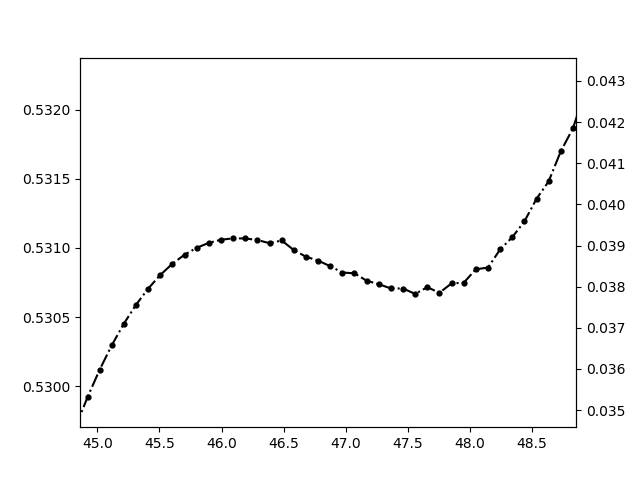

"\nfig = plt.figure(figsize=(8, 16))\n\nplt.subplot(311)\nsetBwStyles(fig.gca())\nplt.plot(x, h, marker=' ', label='h_' + str(nx))\nplt.legend()\n\nplt.subplot(312)\nsetBwStyles(fig.gca())\nplt.plot(x, h, marker=' ', label='h_' + str(nx))\nplt.xlim([43, 49])\nplt.ylim([0.5305, 0.5315])\nplt.legend()\n\nplt.subplot(313)\nsetBwStyles(fig.gca())\nplt.plot(x, h, marker=' ', label='h_' + str(nx))  \nplt.xlim([53, 56.5])\nplt.ylim([0.566, 0.57])\nplt.legend()\n"

In [17]:
fig, ax1 = plt.subplots()
setBwStyles(fig.gca())
ax1.plot(x, h, marker='.', label='h_' + str(nx))
ax2 = ax1.twinx()
ax2.plot(x, hu, marker='+', label='h_' + str(nx))


"""
fig = plt.figure(figsize=(8, 16))

plt.subplot(311)
setBwStyles(fig.gca())
plt.plot(x, h, marker=' ', label='h_' + str(nx))
plt.legend()

plt.subplot(312)
setBwStyles(fig.gca())
plt.plot(x, h, marker=' ', label='h_' + str(nx))
plt.xlim([43, 49])
plt.ylim([0.5305, 0.5315])
plt.legend()

plt.subplot(313)
setBwStyles(fig.gca())
plt.plot(x, h, marker=' ', label='h_' + str(nx))  
plt.xlim([53, 56.5])
plt.ylim([0.566, 0.57])
plt.legend()
"""

<IPython.core.display.Javascript object>


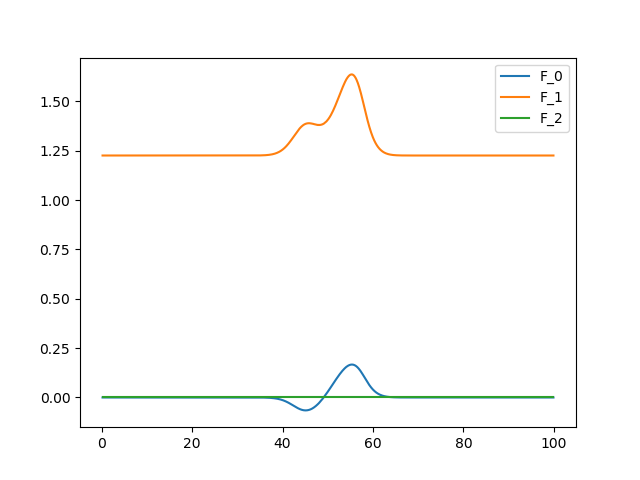

In [11]:
F = WAF_1D_flux_helper(h, hu, g, dx, dt)
plt.figure()
for i in range(F.shape[1]):
    plt.plot(x[2:-1], F[:,i], marker=' ', label='F_' + str(i))
#plt.ylim(-10, 10)
plt.legend()

<IPython.core.display.Javascript object>


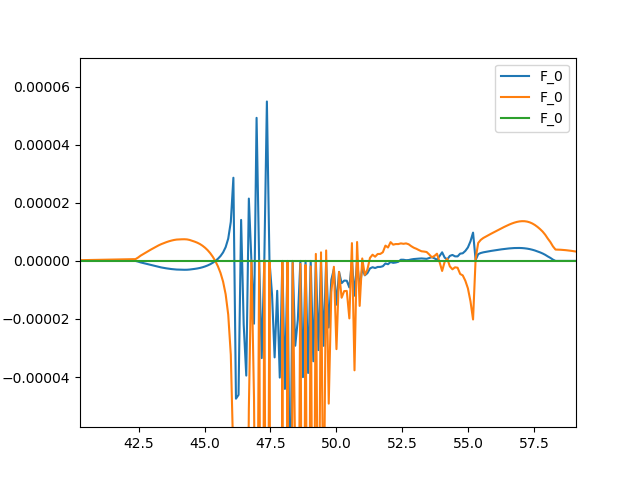

In [14]:
F = WAF_1D_flux_helper(h, hu, g, dx, dt)
plt.figure()
for i in range(1):
    plt.plot(x[2:-1], F[:,i]-F[:,i+1], marker=' ', label='F_' + str(i))
#plt.ylim(-10, 10)
plt.legend()